In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import random

import mnist_fashion_data as mdata
import ml_tools as ml

In [2]:
# Load train/test dataset
train_dataset, test_dataset, label_dict = mdata.load_FashionMNIST_data(verbose=2)

Loading FashionMNIST dataset...
  Training data shape: torch.Size([60000, 28, 28])
  Test data shape: torch.Size([10000, 28, 28])
  Data min,max values: 0,255
  Data labels (10 categories): 0:T-shirt/top, 1:Trouser, 2:Pullover, 3:Dress, 4:Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:Bag, 9:Ankle boot


{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


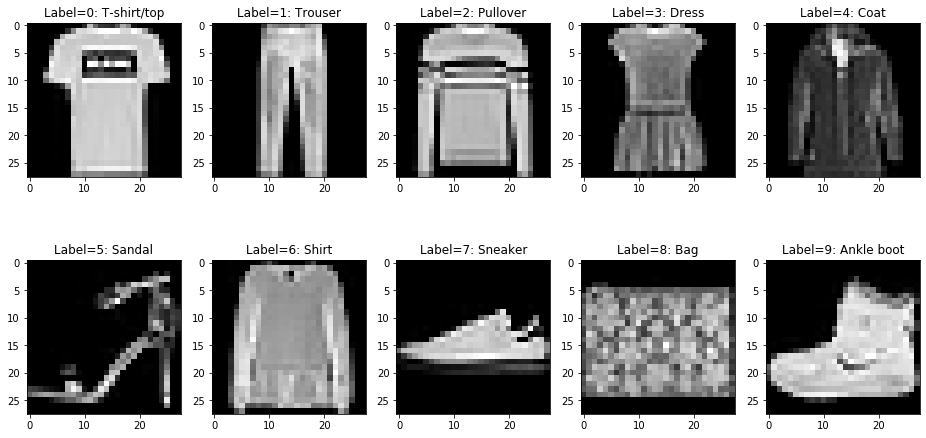

In [3]:
print(label_dict)
# Plot one example image from each category 
mdata.display_example_data(train_dataset, label_dict)

In [4]:
#--------------------------------------------
# Define the LSTM neural net
#--------------------------------------------

class LSTM(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs, n_rnnlayers=1):
        super(LSTM, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        self.lstm = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True)
        self.fc = nn.Linear(self.M, self.K)
    
    def forward(self,X):
        # initial hidden states:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")        
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        h_NxTxM, (h_LxNxM, c_LxNxM) = self.lstm(X, (h0, c0))
        out = self.fc(h_NxTxM[:,-1,:])
        return out

model = LSTM(n_inputs=28, n_hidden=128, n_outputs=10, n_rnnlayers=2)

In [5]:
# Check to see if GPU is available and move model to GPU if it is
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('GPU is available?: {}'.format(torch.cuda.is_available()))
print('Using device: {}'.format(device))
model.to(device)    

GPU is available?: True
Using device: cuda:0


LSTM(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [6]:
# Define our loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [7]:
# Utility function to reshape FashionMNIST image data to format needed for LSTM
def reshape_func(input):
    input = input.view(input.size(0), input.size(2), input.size(3))
    return input

In [ ]:
# Use PyTorch built-in data loader to deal with batch creation and shuffling
#    (for batch gradient descent, because we don't want to load the whole dataset into memory all at once!)\
batch_size = 256
train_loader, test_loader = mdata.get_dataloaders(train_dataset, test_dataset, 
                                                  batch_size=batch_size)

# Train the model!
train_losses, test_losses = ml.train(train_loader, model, optimizer, criterion,
                                     device=device, n_epochs=20, test_loader=test_loader, 
                                     reshape_inp=reshape_func, verbose=1, print_every=1)

Training NN through 20 epochs.  Start time: 2021-01-22 23:32:10.319099
 Iteration   0, avg train_loss = 0.879, avg test_loss = 0.590,1 epoch duration: 0:00:06.244342
 Iteration   1, avg train_loss = 0.496, avg test_loss = 0.473,1 epoch duration: 0:00:06.012865
 Iteration   2, avg train_loss = 0.428, avg test_loss = 0.431,1 epoch duration: 0:00:06.144290
 Iteration   3, avg train_loss = 0.387, avg test_loss = 0.408,1 epoch duration: 0:00:05.997793
 Iteration   4, avg train_loss = 0.363, avg test_loss = 0.378,1 epoch duration: 0:00:06.223156
 Iteration   5, avg train_loss = 0.344, avg test_loss = 0.374,1 epoch duration: 0:00:06.340912
 Iteration   6, avg train_loss = 0.332, avg test_loss = 0.357,1 epoch duration: 0:00:06.537972
 Iteration   7, avg train_loss = 0.315, avg test_loss = 0.339,1 epoch duration: 0:00:06.372788
 Iteration   8, avg train_loss = 0.300, avg test_loss = 0.327,1 epoch duration: 0:00:06.041892
 Iteration   9, avg train_loss = 0.293, avg test_loss = 0.325,1 epoch dura

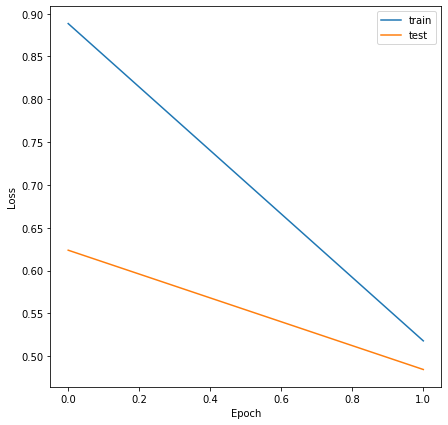

In [9]:
# Plot the losses
ml.plot_losses(train_losses, test_losses)

In [10]:
# Get model predictions
train_predictions, train_targets = ml.predict(train_loader, model, device=device, 
                                              reshape_inp=reshape_func, multiclass=True)
test_predictions, test_targets = ml.predict(test_loader, model, device=device, 
                                            reshape_inp=reshape_func, multiclass=True)
    
# Get overall accuracy
ml.get_accuracy(train_predictions, train_targets, test_predictions, test_targets)

---------------------------------------
Training set accuracy: 0.8270
    Test set accuracy: 0.8191


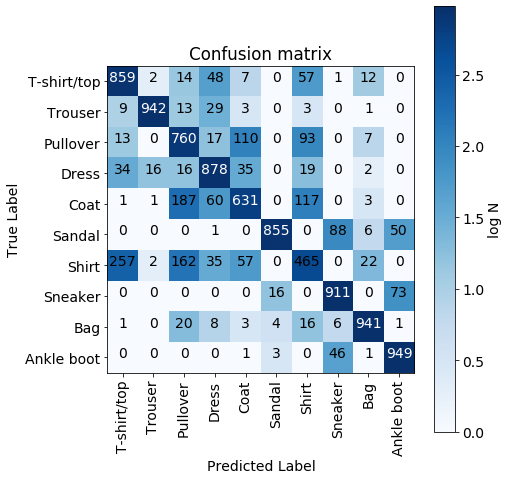

In [11]:
ml.plot_confusion_matrix(test_targets, test_predictions, labels=label_dict, log_color=True)

------------- Test Set: ---------------
# Correct predictions: 8191
  # Wrong predictions: 1809
---------------------------------------
Examples our model got wrong:


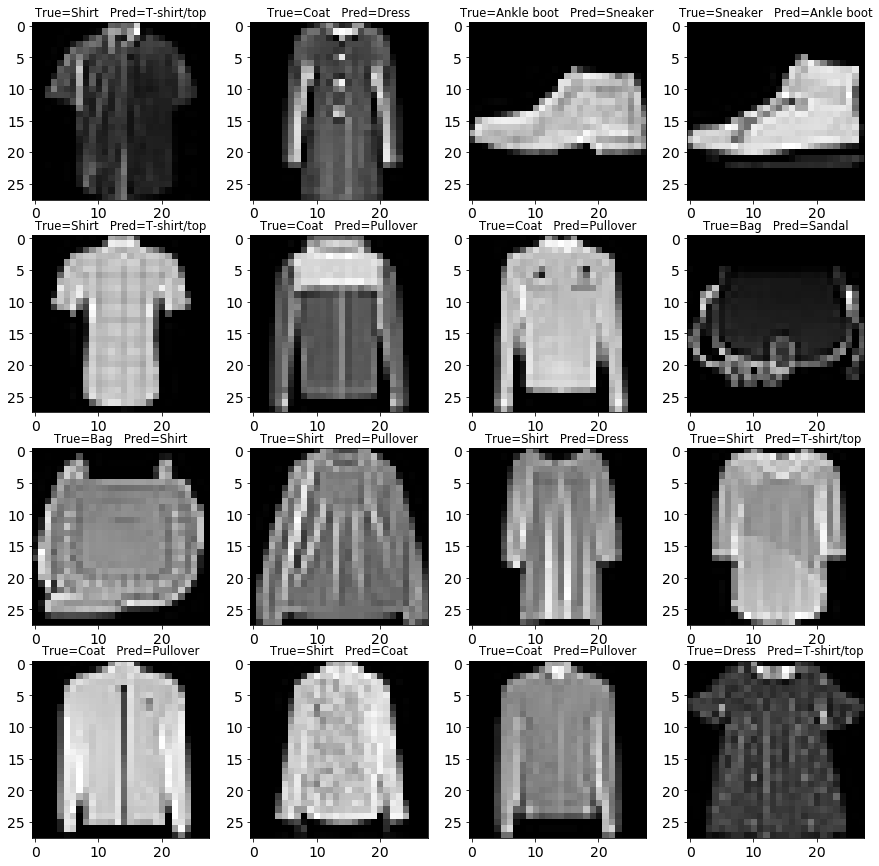

In [13]:
# Plot examples of images we got wrong
correct, wrong = ml.get_correct_wrong(test_predictions, test_targets)
print('Examples our model got wrong:')
mdata.display_pred_examples(wrong,test_dataset, test_targets, test_predictions,label_dict)